# Multiplicative linear models

本节需要的包：


In [2]:
require(s20x)


## Mean versus median – which to use?

接下来我们会看到一个关于房价的数据集：典型的奥克兰郊区房价。


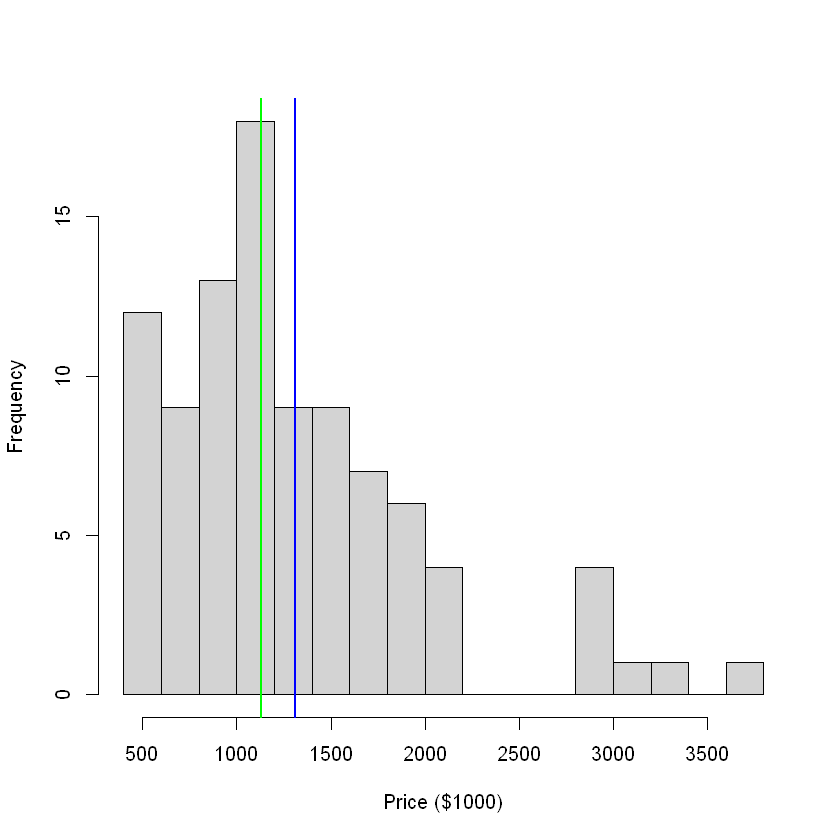

In [2]:
library(s20x)
Houses.df <- read.table("../data/AkldHousePrices.txt", header = T)

hist(Houses.df$price, breaks = 20, main = "", xlab = "Price ($1000)")
abline(
    v = c(mean(Houses.df$price), median(Houses.df$price)),
    col = c("blue", "green"), lwd = 2
)
# 中位值为绿色，均值为蓝色


这个数据就是典型的右偏：中位值比均值更小，因为右偏的分布有更多的更“离谱”的大值，整体却更偏向于小值


In [3]:
summary(Houses.df$price)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  450.0   832.5  1130.0  1310.1  1597.5  3710.0 

This type of right-skew distribution is very common when it comes to things involving money ($$$), resources, growth, salary, age, advantage and energy, to name but a few. 这种类型的右偏分布是非常常见的东西涉及金钱（￥￥￥）时，资源，经济增长，工资，年龄和能源优势，等等，不一而足。

Here is the bootstrap 95% CI for the expected price, along with output from the null model. 从数据中抽取了 1000 次，然后看抽取的数值在 5% 和 95% 之间的数值的分布情况，就是这个 95% 的置信区间。


In [4]:
bootstrappedMeanPrices <- replicate(
    1000,
    mean(sample(Houses.df$price, size = nrow(Houses.df), replace = T))
)

# 95% 置信区间
quantile(bootstrappedMeanPrices, c(.025, .975))

HousesNull.fit <- lm(price ~ 1, data = Houses.df)
summary(HousesNull.fit)
confint(HousesNull.fit)


2.5%    97.5% 
1163.503 1450.407


Call:
lm(formula = price ~ 1, data = Houses.df)

Residuals:
   Min     1Q Median     3Q    Max 
-860.1 -477.6 -180.1  287.4 2399.9 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1310.1       70.1   18.69   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 679.7 on 93 degrees of freedom


2.5 %    97.5 %  
(Intercept) 1170.899 1449.313

上述的操作说明其实这个数据是满足中心极限定理的。

To estimate the median sale price of the entire suburb the natural estimate is the median of our sample 估计整个郊区的平均销售价格自然估计的样本中位数：


In [5]:
median(Houses.df$price)


[1] 1130

and we can use a bootstrap to get a 95% CI for the suburb median 我们可以使用一个引导郊区的 95% 中值可信区间值：


In [6]:
bootstrappedMedianPrices <- replicate(
    1000, median(sample(Houses.df$price, size = nrow(Houses.df), replace = T))
)
quantile(bootstrappedMedianPrices, c(.025, .975))


2.5%   97.5% 
1035.00 1320.25

房价在上面的例子中,我们正在与 iid（Independent and Identically Distributed Data，独立和同分布数据）数据,所以很自然的使用示例值来估计人口值。在下一节中我们将看到，线性模型框架还可以用来进行推理所提供的值，记录反应变量为正态分布。这种方法的优点是它也适用于更一般的情况下我们有解释变量可能与响应变量联系在一起。我们也会看到登录响应数据结果拟合线性模型解释变量的影响作用在中位数用乘法。


## Transforming the response variable using the log function


Let’s consider making a transformation of the prices. In particular(特别是), the log transformation. Here is the histogram of `log(price)`.


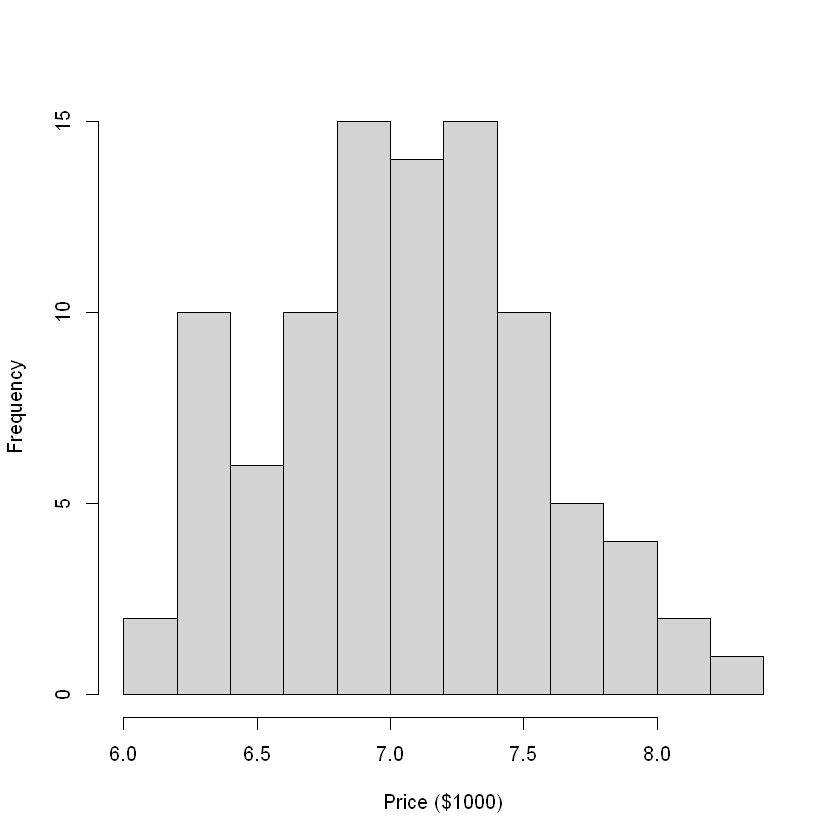

In [7]:
hist(log(Houses.df$price), breaks = 12, main = "", xlab = "Price ($1000)")


This looks reasonably(合理的，相当的) close to normal, so if we fit a linear model to these data then all inferences(推论) will be valid(有效的).


In [8]:
LoggedPriceNull.fit <- lm(log(price) ~ 1, data = Houses.df) # 取对数
# log函数可以带底数参数 base；默认底数为 e（这里就是默认底数）
coef(summary(LoggedPriceNull.fit)) # 估计系数
confint(LoggedPriceNull.fit) # 置信区间


Estimate Std. Error t value  Pr(>|t|)     
(Intercept) 7.060405 0.04974049 141.9448 1.628721e-110

2.5 %   97.5 % 
(Intercept) 6.96163 7.15918

这很有趣，但记录房价不意味着很多人希望买一栋房子。推理需要 back-transformed 价格（新西兰元）。

Since we’ve used the log transformation(转换), the back-transformation(回转) is the exponential(指数的) function `exp()`


In [9]:
exp(confint(LoggedPriceNull.fit))
# exp函数同样可以带底数参数 base；同上。


2.5 %    97.5 %  
(Intercept) 1055.353 1285.856

上述计算置信区间是完全不同于我们的平均房价郊区。上面的原因是因为算的房价中值。明白这是为什么,让我们看看会发生什么当我们变换摘要统计信息使用和功能：


In [10]:
# Summaries of price
summary(Houses.df$price)
# Summaries of log(price)
summary(log(Houses.df$price))
# Back-transformed summaries of log(price)
exp(summary(log(Houses.df$price)))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  450.0   832.5  1130.0  1310.1  1597.5  3710.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.109   6.724   7.030   7.060   7.376   8.219 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  450.0   832.5  1130.0  1164.9  1597.0  3710.0 

Our back-transformed estimate(估计) ($exp(\hat{\beta}_0)$) and 95% CI(Confidence interval, 置信区间) for the median suburb sale price(郊区销售价格) are:


In [11]:
exp(coef(LoggedPriceNull.fit)) # 估计系数（Intercept）
exp(confint(LoggedPriceNull.fit)) # Intercept 的置信区间


(Intercept) 
   1164.917

2.5 %    97.5 %  
(Intercept) 1055.353 1285.856

## The log function turns multiplicative effects in to additive effects


## Example 1: Multiplicative simple linear regression model

乘法简单线性回归模型是一个线性模型，其中响应变量是一个或多个自变量的乘积。这是一个非常简单的模型，但是它是一个很好的起点，因为它可以用来解释一些非常有趣的现象。


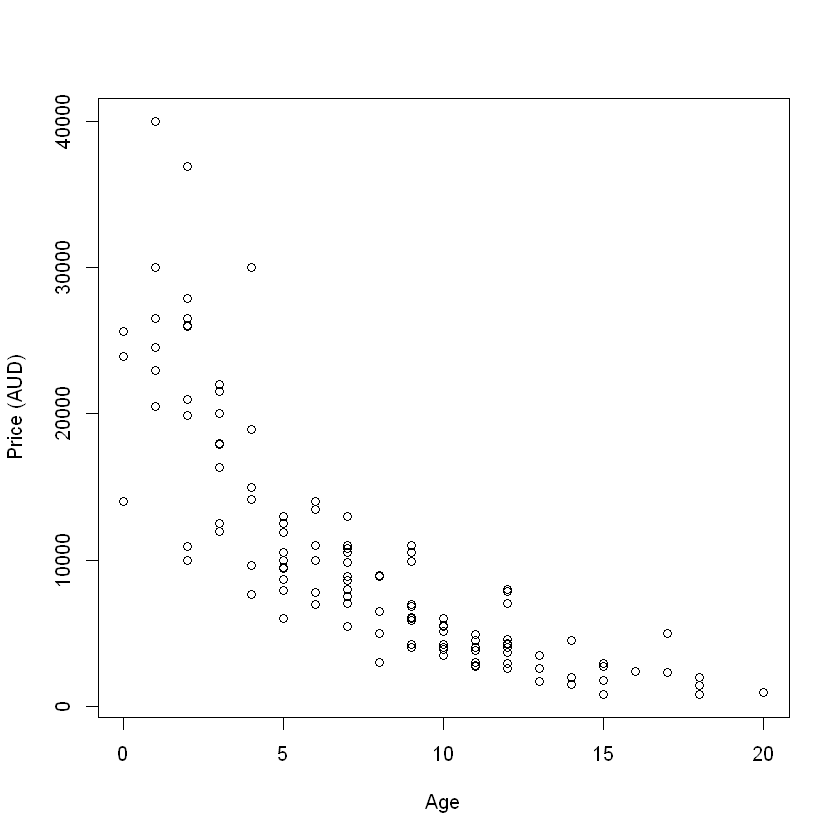

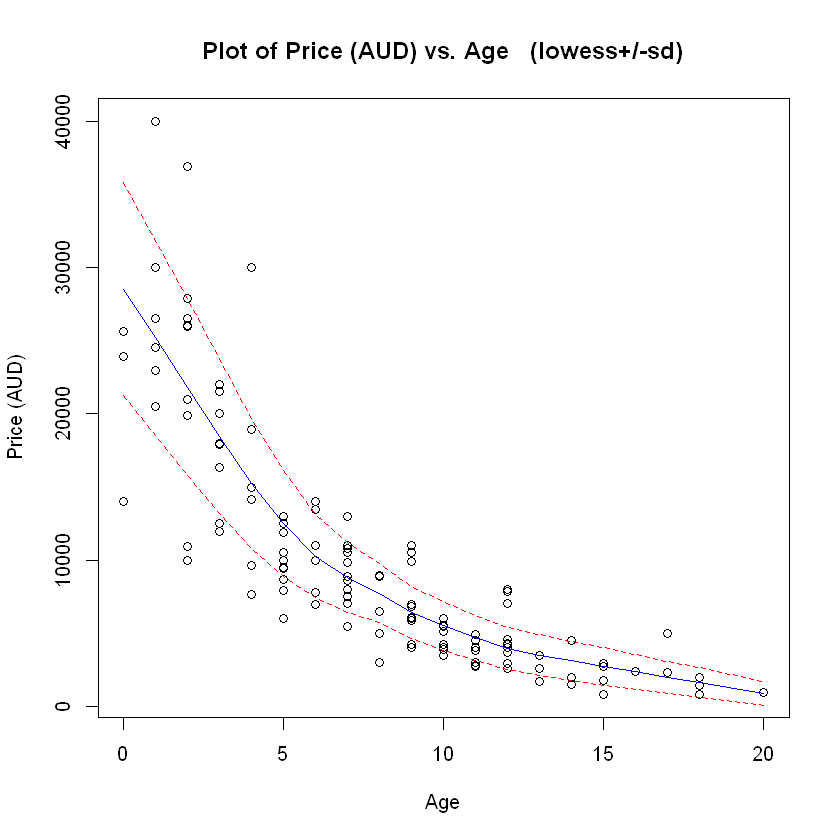

In [12]:
Mazda.df <- read.table("../data/mazda.txt", header = T)
Mazda.df$age <- 91 - Mazda.df$year # Create the age variable
plot(price ~ age, data = Mazda.df, xlab = "Age", ylab = "Price (AUD)")

trendscatter(
    price ~ age,
    data = Mazda.df, xlab = "Age", ylab = "Price (AUD)"
)


`trendscatter()` 函数给出的蓝线代表均值，红色线代表均值区间。

趋势是减少（指数），以及减少散射这些都是一个潜在的乘法模型的典型症状。假 Assuming would be na ̈ıve in this case. Let us be na ̈ıve and see where it takes us.让我们适应一个线性模型，看看剩余情节告诉我们什么。


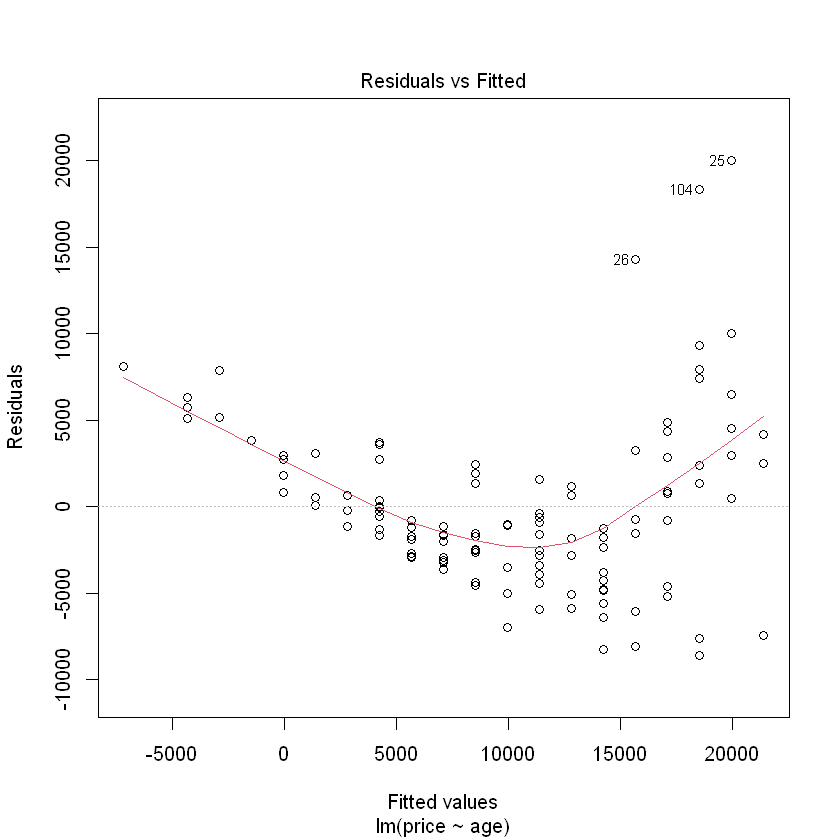

In [13]:
PriceAge.fit <- lm(price ~ age, data = Mazda.df)
plot(PriceAge.fit, which = 1)


非线性下降趋势和不恒定散射已经变得更加明显。

Na ̈ıve price vs age models... 适应价格与年龄模型...


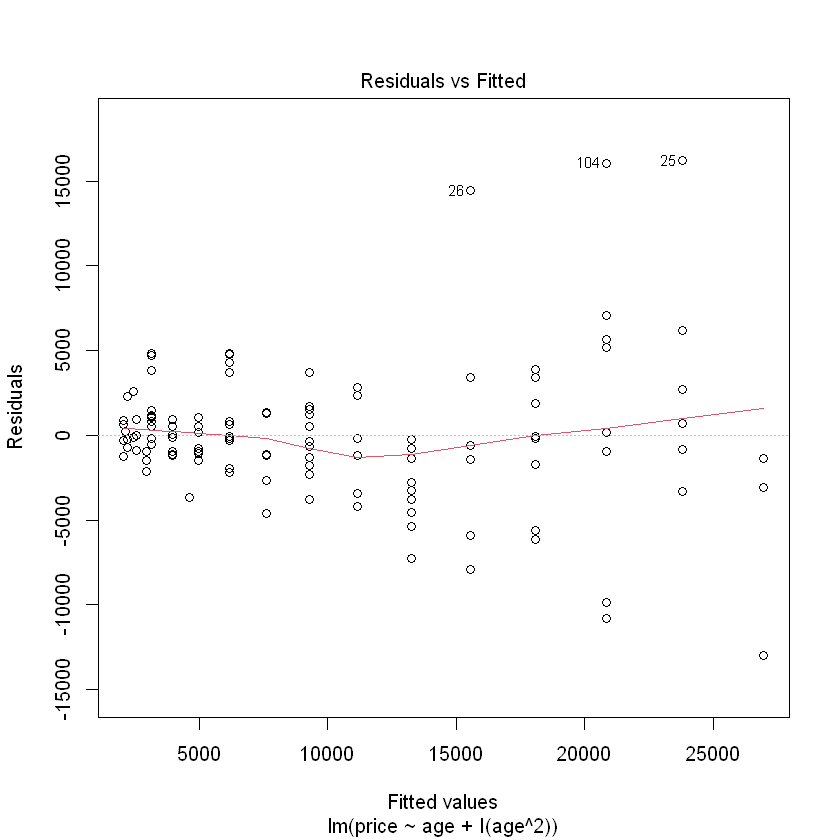

In [14]:
PriceAge.fit2 <- lm(price ~ age + I(age^2), data = Mazda.df)
plot(PriceAge.fit2, which = 1)


We have eliminated trend from these residuals but the assumption is still violated. 我们从这些残差但假设消除趋势仍然是违反了。Let us ‘tear up’ this approach and take logs of price.


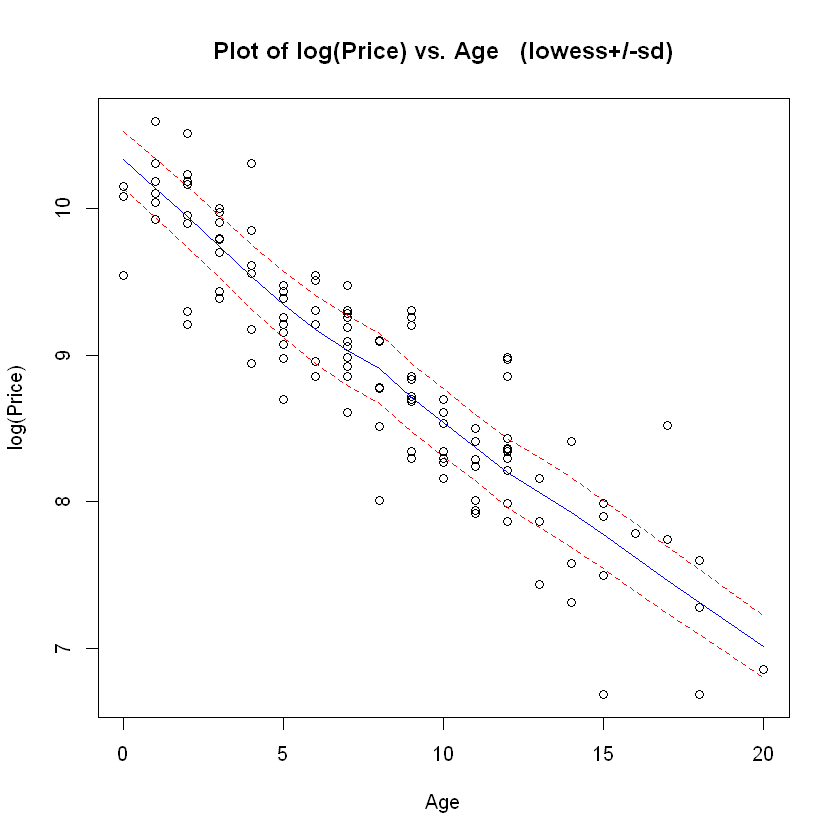

In [15]:
# log(Price)
trendscatter(
    log(price) ~ age,
    data = Mazda.df, xlab = "Age", ylab = "log(Price)"
)


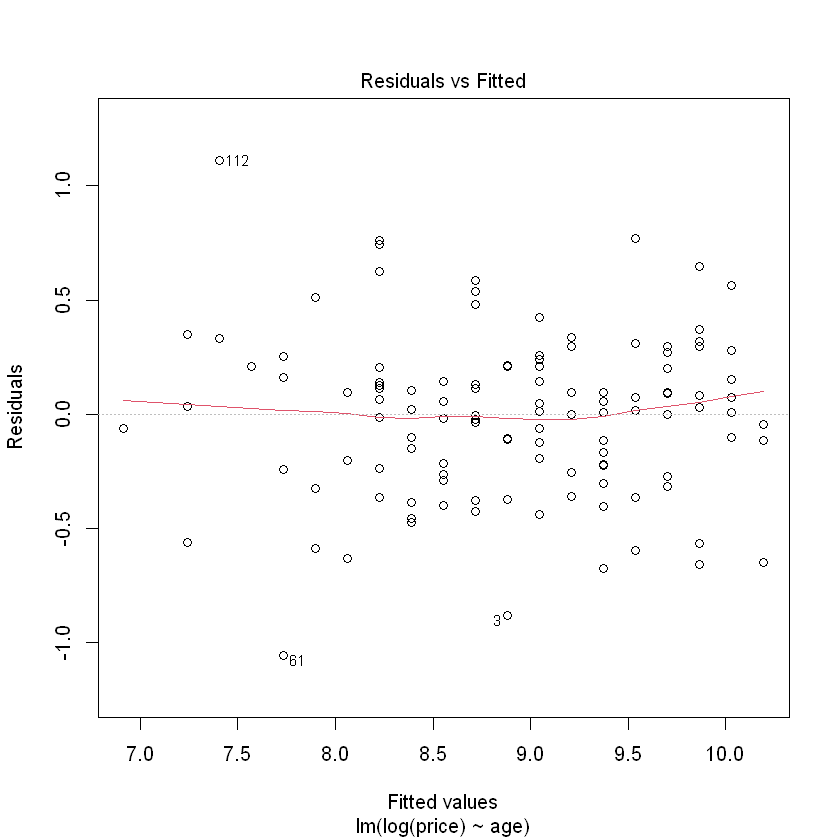

In [16]:
LogPriceAge.fit <- lm(log(price) ~ age, data = Mazda.df)
plot(LogPriceAge.fit, which = 1)


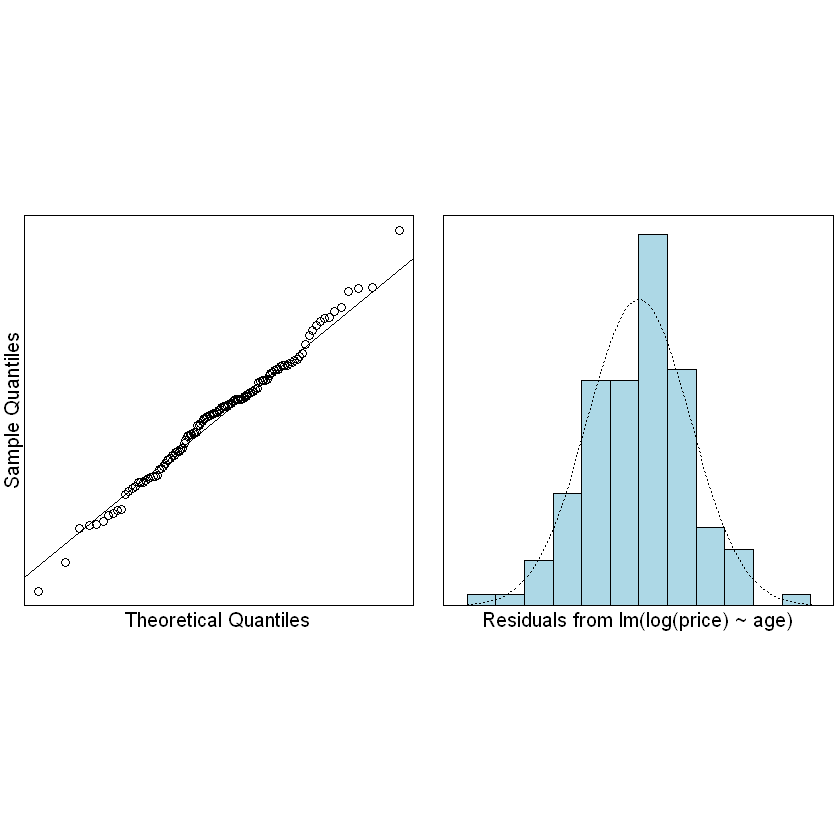

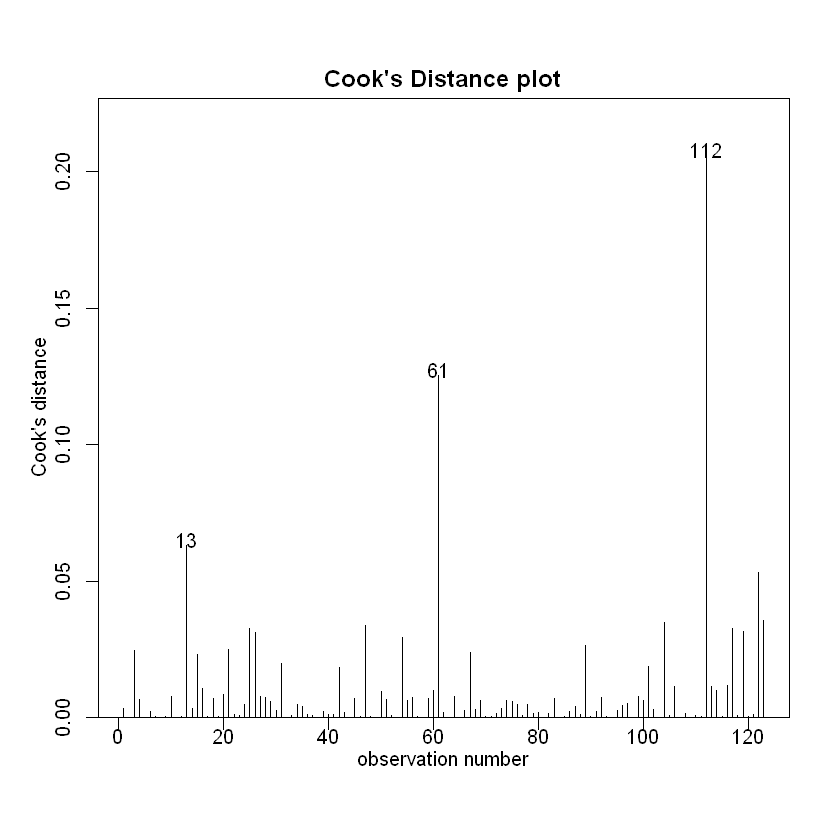

In [17]:
# Check for normality of the residuals.
normcheck(LogPriceAge.fit)
# Check for unduly influential data points.
cooks20x(LogPriceAge.fit)


In [18]:
summary(LogPriceAge.fit)
confint(LogPriceAge.fit)



Call:
lm(formula = log(price) ~ age, data = Mazda.df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0531 -0.2398  0.0311  0.2110  1.1085 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.195210   0.063602   160.3   <2e-16 ***
age         -0.163915   0.007034   -23.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3615 on 121 degrees of freedom
Multiple R-squared:  0.8178,	Adjusted R-squared:  0.8163 
F-statistic: 543.1 on 1 and 121 DF,  p-value: < 2.2e-16


2.5 %      97.5 %    
(Intercept) 10.0692935 10.3211263
age         -0.1778406 -0.1499902

我们可以获得置信区间的中间价格的一辆新车回转换得到的中值，就像我们前面讨论的零模型。


In [19]:
exp(confint(LogPriceAge.fit))


2.5 %        97.5 %      
(Intercept) 2.360688e+04 3.036744e+04
age         8.370758e-01 8.607164e-01

In [20]:
100 * (exp(confint(LogPriceAge.fit)[2, ]) - 1)


2.5 %    97.5 % 
-16.29242 -13.92836

This says that our 95% CI for the annual depreciation in median price of Mazda cars is between $100\% × (1 - 0.861) = 13.9\%$ and $100\% × (1 - 0.837) = 16.3\%$


## Example 2: Multiplicative model with categorical explanatory variable


         Sample Size  Mean Median  Std Dev Midspread
Standard          25 4.600    3.3 4.983138       3.8
Tapered           25 1.924    1.4 1.643999       1.4


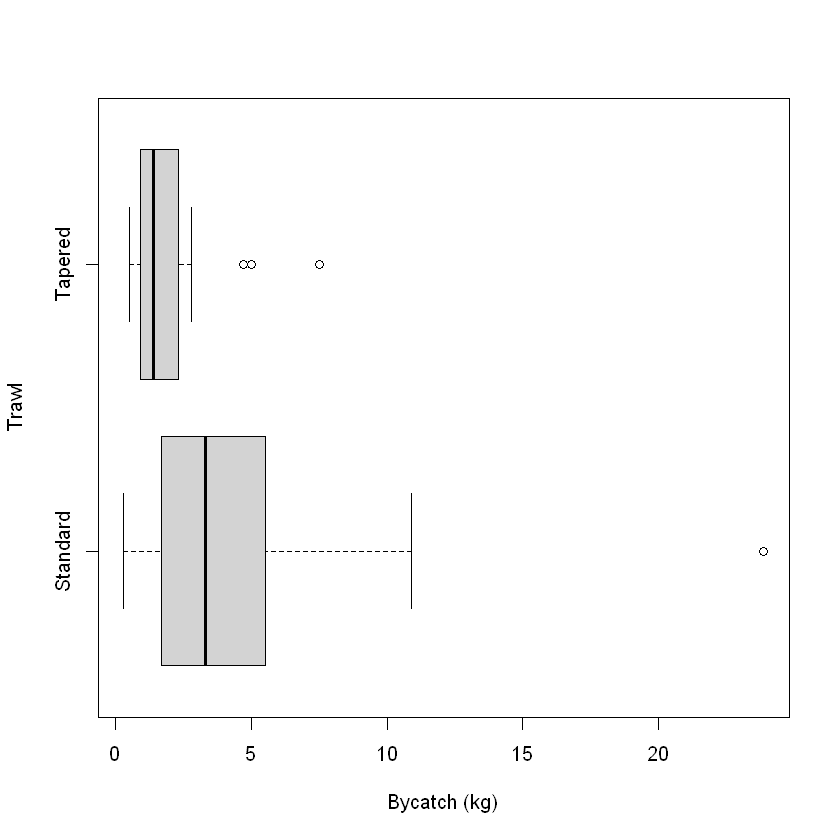

In [23]:
Bycatch.df <- read.table("../data/Bycatch.txt", header = T)
boxplot(Bycatch ~ Trawl, data = Bycatch.df, horizontal = T, xlab = "Bycatch (kg)")
summaryStats(Bycatch ~ Trawl, data = Bycatch.df)


这似乎证实了我们的直觉，这些数据应该仿照对数尺度。线性模型的拟合效果真的很差...


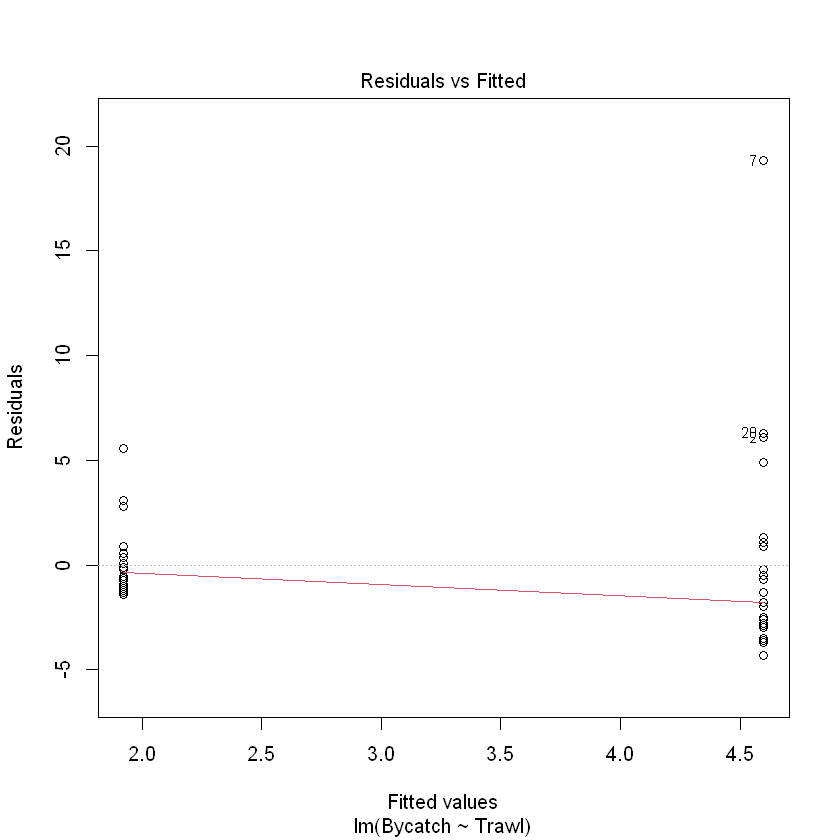

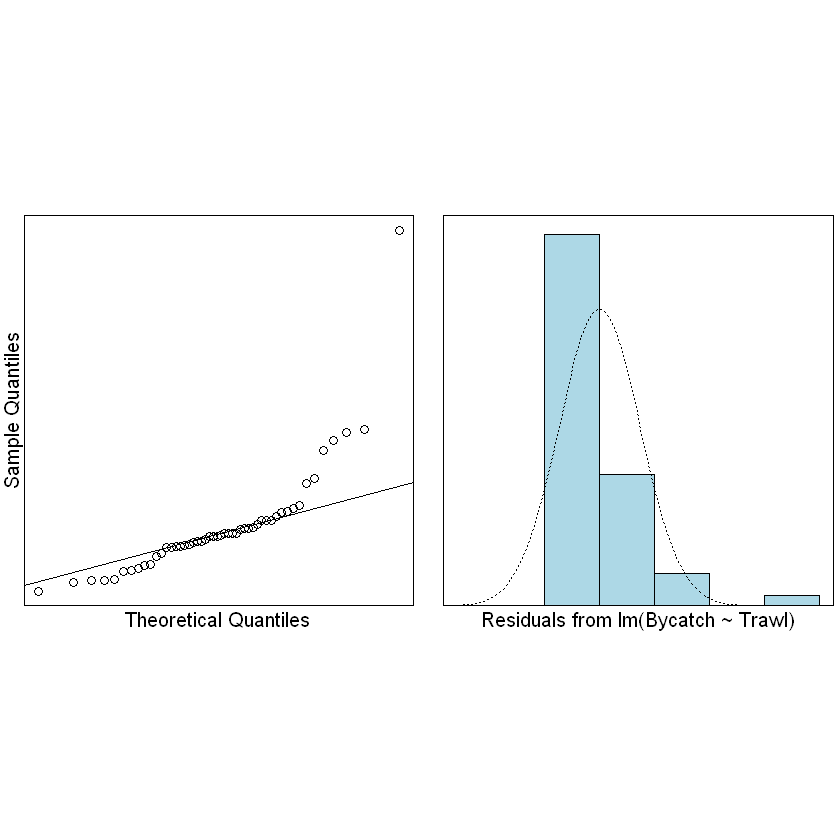

In [25]:
Trawl.lm <- lm(Bycatch ~ Trawl, data = Bycatch.df)
plot(Trawl.lm, which = 1)
normcheck(Trawl.lm)


Multiplicative model with categorical explanatory variable 乘法模型分类解释变量


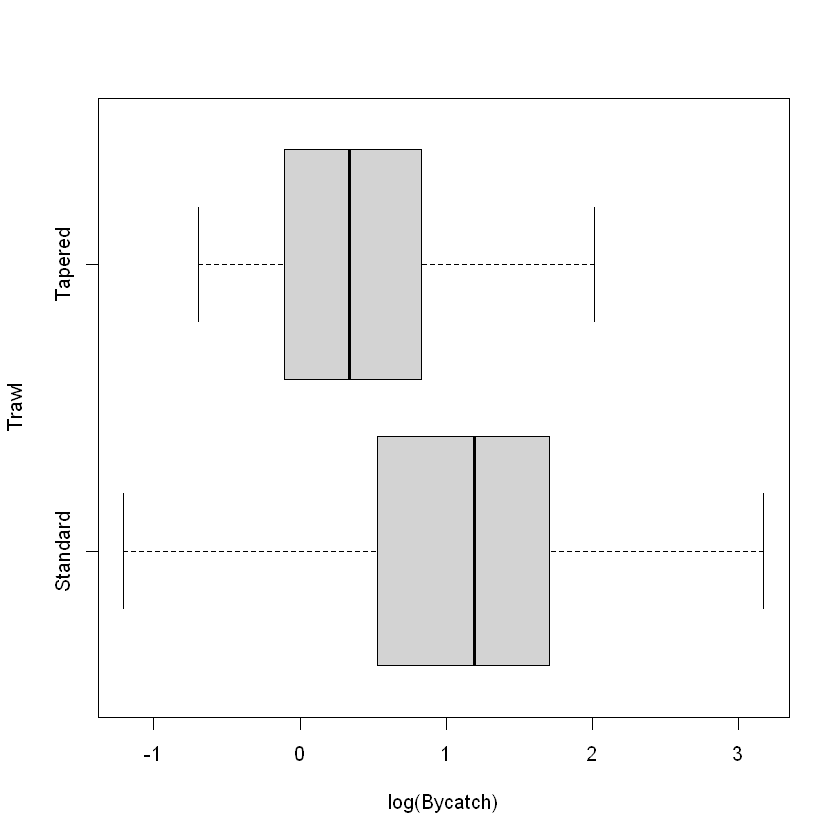

In [26]:
boxplot(log(Bycatch) ~ Trawl, data = Bycatch.df, horizontal = T, xlab = "log(Bycatch)")


Looking much better.

接下来我们将进行建模 + 验证三部曲。


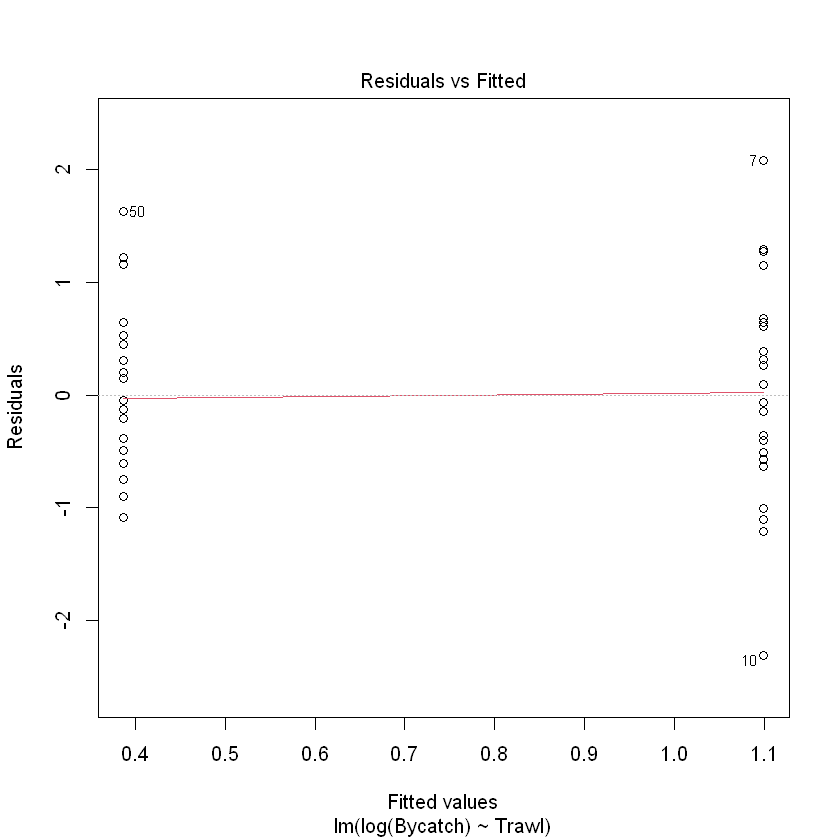

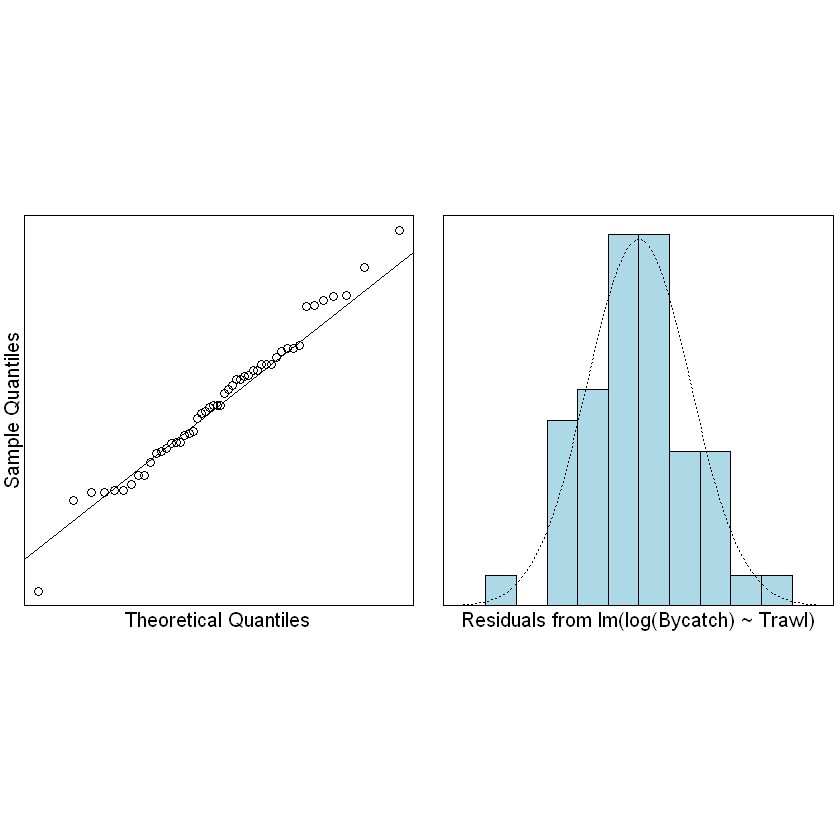

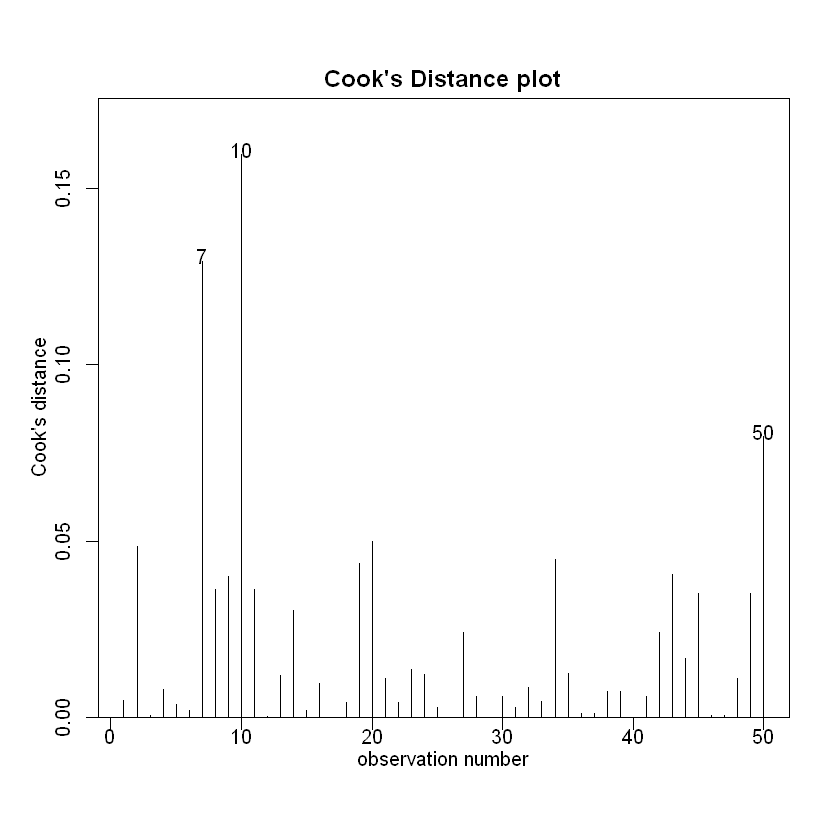

In [27]:
Trawl.lmlog <- lm(log(Bycatch) ~ Trawl, data = Bycatch.df)
plot(Trawl.lmlog, which = 1)
normcheck(Trawl.lmlog)
cooks20x(Trawl.lmlog)


Assumptions are satisfied. We can trust the fitted model.


In [28]:
summary(Trawl.lmlog)



Call:
lm(formula = log(Bycatch) ~ Trawl, data = Bycatch.df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.30353 -0.55464 -0.05088  0.44556  2.07432 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.0996     0.1700   6.469 4.79e-08 ***
TrawlTapered  -0.7122     0.2404  -2.963  0.00473 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8498 on 48 degrees of freedom
Multiple R-squared:  0.1546,	Adjusted R-squared:  0.137 
F-statistic:  8.78 on 1 and 48 DF,  p-value: 0.004728


There is a statistically significance effect of trawl type(trawl type 的影响有统计学意义) ($P-value \approx 0.05$). However, our model only explained 15% of the variability in the logged data and will not be very good for prediction. 然而,我们的模型只能解释 15%的变异在记录数据，并不能很好的预测。


In [29]:
exp(confint(Trawl.lmlog))


2.5 %     97.5 %   
(Intercept)  2.1336329 4.2261691
TrawlTapered 0.3025531 0.7953873

附模型方程：

$$
\log(y) = \beta_0 + \beta_1 \times \text{x} + \epsilon
$$

什么时候直接用线性模型，什么时候要取对数？

有明显的正态分布或者线性关系就可以用线性模型，否则就要取对数。当然我们也可以通过“右偏”效果来看取对数的必要性（其中之一：中位值比均值要小一点）。事实上取对数也只是为了更好的拟合模型，是手段而非万能方法。
